In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import factorial
from scipy.stats import poisson, norm

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Q1
One of the grad students in the Astronomy department mentioned recently that in elementary school, there were 10 sets of twins and 1 set of triplets in her grade of around 100 people! For HW1, I'll look at whether this signal (redefined to be 11 multiple births among 100 households) is significantly greater than the background rate of multiple births per 100 households

## a. 
### Define Poisson distribution and take samples
From the 1995 CDC Report of Final Natality Statistics 1995, there were 26.1 multiple births per 1000 in 1995. So for a grade of ~100 households, we might expect the number of multiple births per 100 households to be roughly $\frac{26.1}{1000}\times{100} = 2.61$

Since multiple births are fairly rare, we will assume that the background distribution is Poisson, with $\lambda = 2.61$ multiple births per 100 households.

In [3]:
ev = 2.61 # expected value for poisson distribution
n_samples = int(1e6)
sample = poisson.rvs(ev, size=n_samples)

### Plot background events

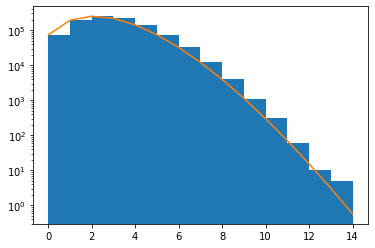

In [4]:
plt.hist(sample, bins = np.arange(0, max(sample)+1))

t = np.arange(0, max(sample)+1, 1)
d = np.exp(-ev)*np.power(ev, t)/factorial(t)

# plt.plot(t, d * n_samples)
plt.plot(t, poisson.pmf(t, ev) * n_samples)
plt.yscale('log')
# plt.axvline(signal, color='k')
plt.show()

## b.
### Define our candidate signal
As stated earlier, we found 11 sets of multiple births in a single grade of ~100 households. As such, our "signal" is 11. We want to know how plausible it is for this to have occured by chance (i.e. due to the background), assuming all of our assumptions are correct. Thus, "as signal like" means 11 multiple births per 100 and "more signal like" means more than 11 multiple births per 100.

In [5]:
signal = 11

Converting this to an integral (sum since our distribution is discrete), we have that the probability that our "signal" is due to the background is:
$$ \sum^{\inf}_{k=11} Poisson(k, \lambda=2.61)$$
In reality, we might sum up to k=100, since that's the maximum biologically possible k in our situation with 100 households. This isn't a huge difference since $Poisson(k=100+, \lambda=2.61)$ is very small

# c.
### Determine probability for the background creating this event

To do this empirically, using our background, we count the number of samples equal to, or exceeding our signal

In [6]:
p = sum(sample >= signal) / n_samples
p

7.5e-05

We could also do this analytically by taking the sum, which gives 8.96e-5.

## d. 
### Determine the 'sigma' of the candidate
We then convert this probability to the sigma value of a standard normal distribution

In [7]:
norm.ppf(1 - p)

3.791069448636699

For our "signal" of 11 multiple births, our value for sigma is about 3.7. While this might not meet the $5\sigma$ detection threshold for physics, it is sufficiently high that we might begin to wonder if there are other factors at play to cause such a high number of families with twins to reside in the same school district.

# Q3

## a.
If our question is to investigate whether there are external factors causing so many sets of twins/multiple births in the same area, then we might want to look at other grades, or the same grade in nearby schools. This would approximate taking multiple observations of a phenomenon in the lab (although it wouldn't be exactly the same, since there could be other confounding factors for a different grade or a different school). While the grad student with this anecdote doesn't know how many other sets of twins/triplets/etc were in the other grades, lets just say that in the other 4 grades, there were 7, 3, 2, and 5 sets of multiple births per 100. Thus our average signal across all 5 observations is 7.

In [8]:
avg_signal = 7

In [9]:
n = 5 # number of observations to average together
n_samples = 10000000 # increased 10x
samples = []
for ii in range(n):
    samples.append(poisson.rvs(ev, size=n_samples))
    
avgs = sum(samples) / n

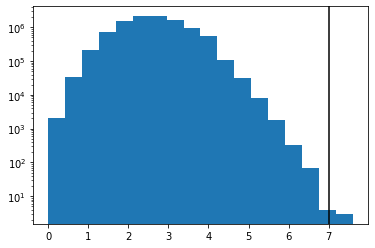

In [10]:
plt.hist(avgs, bins=18)
# plt.plot(t, norm.pdf(t, ev, ev/np.sqrt(n)) * 300000)
plt.axvline(avg_signal, color='k')
plt.yscale('log')
plt.show()

As the number of observations are averaged together, the signal needed for a significant result decreases. Even with averaging 5 observations, and with an average signal now of 7 instead of 11, we see that our "signal" is highly significant compared to the background of multiple births. 

In [11]:
p_avg = sum(avgs >= avg_signal) / n_samples

In [12]:
norm.ppf(1 - p_avg)

4.991217139937879

This is actually 5 sigma. So an average of 7 multiple births per 100 in each grade in 5 different grades would meet the phycisist's publication criteria of a 5-sigma detection! Note that as the number of observations averaged increases, so does the significane of any result that's far from the sample, since the noise distribution becomes tighter (and more Gaussian)

In [13]:
n = 30 # number of observations to average together
n_samples = 1000000
samples = []
for ii in range(n):
    samples.append(poisson.rvs(ev, size=n_samples))
    
avgs = sum(samples) / n

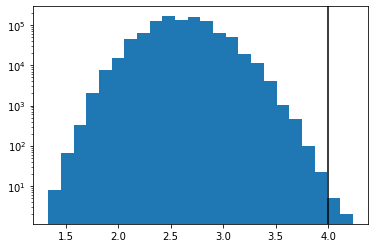

In [14]:
plt.hist(avgs, bins=24)
plt.axvline(4, color='k')
plt.yscale('log')
plt.show()

In [15]:
p_avg2 = sum(avgs >= 4) / n_samples

With thirty samples, the background distribution is much tighter, so even an average signal of 4 would be highly significant. Note how the averaged distribution looks very much like a gaussian.

## b.
The number of observations that must be averaged depends on several factors, such as the skewness of the distribution, and how much one cares about the accuracy in the tails.

In [16]:
from scipy.signal import convolve

In [17]:
empirical_distr, bins = np.histogram(poisson.rvs(ev, size=n_samples), bins=np.arange(0, 15), normed=True)

### plot empirical distibution

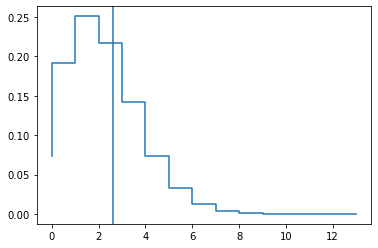

In [18]:
plt.step(bins[:-1], empirical_distr)
plt.axvline(ev)

### define functions to plot averaging repeated samples
Where num is the number of samples to average. The gaussian approx has mean $\lambda$ and std equal to the standard error of the mean $\sqrt{\frac{\lambda}{N}}$.

In [19]:
def plot_means(num, random_variable, rv_args = [ev], rv_kwargs = {'size': 1000000}):
    samples = []
    for ii in range(num):
        samples.append(random_variable(*rv_args, **rv_kwargs))
    avgs = sum(samples) / num
    distr, bins = np.histogram(avgs, bins=int((len(np.unique(avgs)+1)/2)), normed=True)
    plt.step(bins[1:], distr, label='Distr. of means of n samples')

def plot_conv_avg(distr, num):
    conv = distr
    for ii in range(num-1):
        conv = convolve(conv, distr)
    plt.plot(np.arange(len(conv)) / num, conv * num, label='n convolutions')


def plot_gauss_approx(num, lmda, n_samples, xmin=0, xmax=10):
    x = np.linspace(xmin, xmax, 100)
    plt.plot(x, norm.pdf(x, loc=lmda, scale=np.sqrt(lmda/n)), label='Gaussian approx')

### plot averaging multiple samples

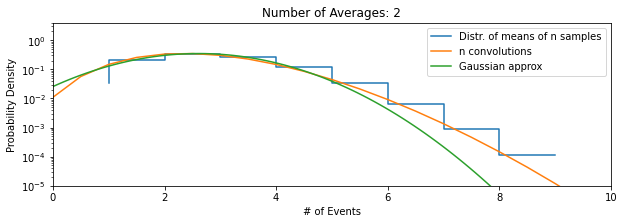

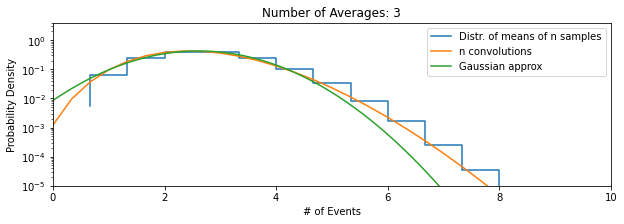

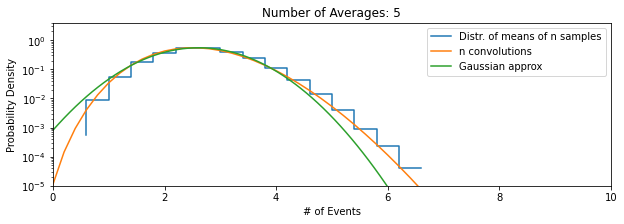

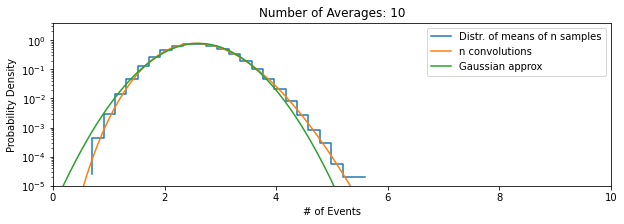

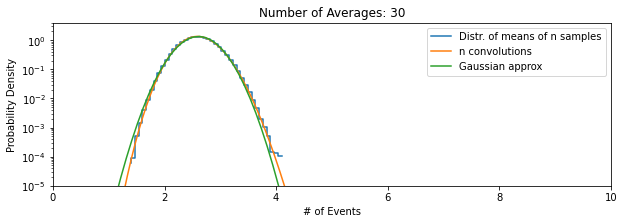

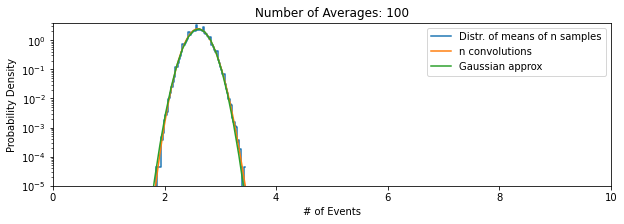

In [22]:
for n in [2, 3, 5, 10, 30, 100]:
    plt.figure(figsize=(10,3))
    plot_means(n, poisson.rvs)
    plot_conv_avg(empirical_distr, n)
    plot_gauss_approx(n, ev, n_samples)
    plt.yscale('log')
    plt.xlim([0, 10])
    plt.ylim([10**-5, 4])
    plt.title('Number of Averages: '+str(n))
    plt.legend()
    plt.xlabel('# of Events')
    plt.ylabel('Probability Density')
    plt.show()

Note that around the peak, the gaussian approximation is quite good, even after only 2-3 averages. However, to get the distriubtions to match closely in the tails, we need many more samples (30+)